# Table of Contents

1. [Setup](#Setup)
2. [Isolate ML Features](#Isolate-ML-Features)
3. [PCA Analysis](#PCA-Analysis)
4. [Machine Learning Algorithms](#Machine-Learning-Algorithms)
    1. [Train-Test Split](#Train-Test-Split)
    2. [Sci-kit Learn Models](#Sci-kit-Learn-Models)
    3. [Deep Learning](#Deep-Learning)
    4. [Ensemble Model](#Ensemble-Model)
5. [Cross Validation](#Cross-Validation)
6. [Feature Importance](#Feature-Importance)

# Setup
[Back to Top](#Table-of-Contents)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os, sys, subprocess
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
# ROOT_DIR - root directory
ROOT_DIR = os.getcwd()+'/'

In [3]:
DF_prest = pd.read_csv(ROOT_DIR+'DF_solubility_features.csv',index_col = 0)
print 'Number of peptides:', len(DF_prest)

Number of peptides: 16082


Mark all peptides above class 4 value as "Soluble", and all peptides below 3 as "Insoluble"

In [4]:
target = 'soluble'
DF_prest.loc[:,target] = DF_prest.solubility_class_1M > 4

Remove all peptides between solubility levels 3 and 4 percentile of expression

In [5]:
DF_prest = DF_prest[(DF_prest.solubility_class_1M != 4)]

print 'Number expressed:',len(DF_prest[DF_prest[target]])
print 'Number not expressed:',len(DF_prest[DF_prest[target]==False])

Number expressed: 7667
Number not expressed: 3324


## Isolate ML Features
[Back to Top](#Table-of-Contents)

In [6]:
aa_features = ['list_comp_A','list_comp_R','list_comp_N',
               'list_comp_D','list_comp_C','list_comp_Q','list_comp_E','list_comp_G',
               'list_comp_H','list_comp_I','list_comp_L','list_comp_K','list_comp_M',
               'list_comp_F','list_comp_P','list_comp_S','list_comp_T','list_comp_W',
               'list_comp_Y','list_comp_V',
               # Amino acid types
               'frac_aliphatic', 'frac_uncharged_polar', 'frac_polar',
               'frac_hydrophobic', 'frac_positive', 'frac_sulfur', 'frac_negative', 'frac_amide',
               'frac_alcohol']

                    
phys_features = ['aa_len',                                        
                # Physical properties
                 'bio_pI','bio_mW','bio_aromaticity','bio_instability','bio_gravy','abs_avg_charge','abs_charge',
                 'avg_charge']
                    

list_of_features = aa_features+phys_features

DF_prest_features = DF_prest[list_of_features]

In [7]:
len(list_of_features)

38

In [8]:
X = DF_prest_features.values
y = DF_prest[target].values
n_samples, n_features = X.shape
print("No. of samples = %d" % n_samples)
print("No. of features = %d" % n_features)

No. of samples = 10991
No. of features = 38


# PCA Analysis
[Back to Top](#Table-of-Contents)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(whiten=True)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

print X_pca.shape
print pca.explained_variance_ratio_[:2]

(10991, 38)
[ 0.13167355  0.11624395]


/home/anand/.virtualenvs/tensorflow/local/lib/python2.7/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


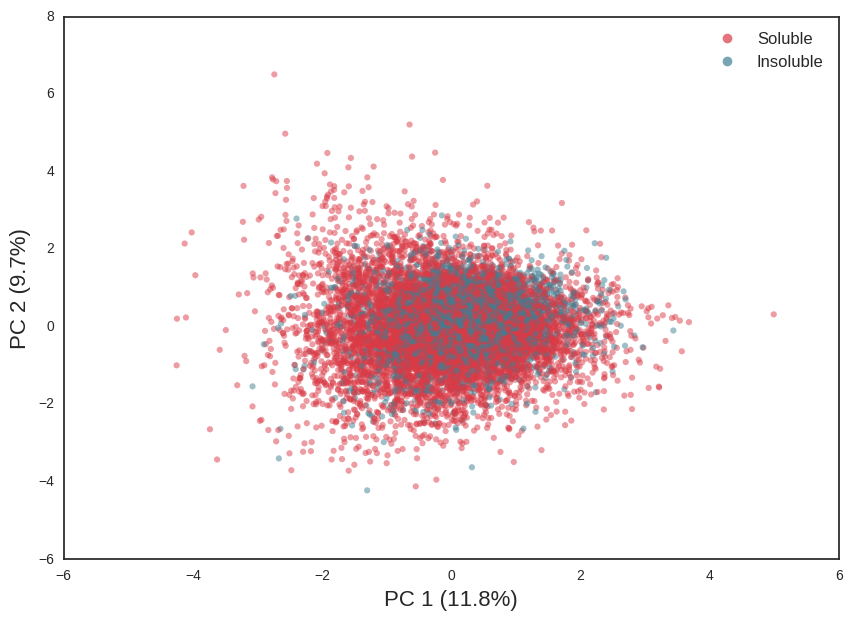

In [10]:
sns.set_style('white')

fig,ax = plt.subplots(figsize=(10,7))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=cmap)

point1 = plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=sns.diverging_palette(220, 10)[-1],alpha=0.7)
point2 = plt.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor=sns.diverging_palette(220, 10)[0],alpha=0.7)

ax.legend((point1,point2),('Soluble','Insoluble'),fontsize=12)
ax.set_xlabel('PC 1 (11.8%)',fontsize=16)
ax.set_ylabel('PC 2 (9.7%)',fontsize=16)

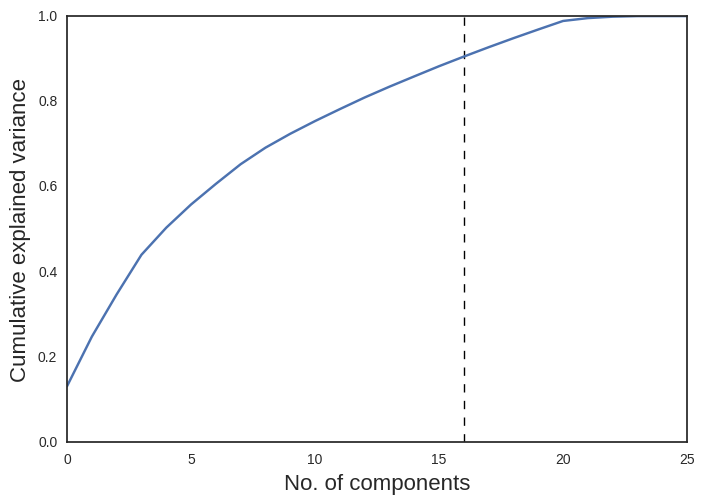

In [11]:
sns.set_style('white')
fig,ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
min_comp = min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0])
ax.vlines(min_comp,0,1,linestyles='dashed',linewidth=1)
ax.set_ylim((0,1))
ax.set_xlim((0,25))

ax.set_xlabel('No. of components',fontsize=16)
ax.set_ylabel('Cumulative explained variance',fontsize=16);

# Machine Learning Algorithms
[Back to Top](#Table-of-Contents)

### Train-Test Split
[Back to Top](#Machine-Learning-Algorithms)

The data will be split into a 70 - 30 split between training and testing sets. After the split, the training data will be scaled to have a mean of 0 and variance 1. This same scaling factor will be applied to the other sets. This ensures that the testing and validation data do not introduce bias in the pre-processing steps.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)


print "Train data shape: %r, Train target shape: %r" % (X_train.shape, y_train.shape)
print "Test data shape: %r, Test target shape: %r" % (X_test.shape, y_test.shape)

print "Train-Test Ratio: %.2f-%.2f" % (np.true_divide(X_train.shape[0],X.shape[0]),
                                                np.true_divide(X_test.shape[0],X.shape[0]))


Train data shape: (7693, 38), Train target shape: (7693,)
Test data shape: (3298, 38), Test target shape: (3298,)
Train-Test Ratio: 0.70-0.30


In [13]:
print "Train - Test data with expressed label:", (y_train==1).sum(),'-',(y_test==1).sum()
print "Train - Test data with not expressed label:", (y_train==0).sum(),'-',(y_test==0).sum()

Train - Test data with expressed label: 5341 - 2326
Train - Test data with not expressed label: 2352 - 972


### Sci-kit Learn Models
[Back to Top](#Machine-Learning-Algorithms)

In [14]:
clf_names = ['Logistic Regression','Support Vector Classifier','Random Forest Classifier','Deep Learning','Ensemble Model']

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

### Logistic Regression
clf1 = LogisticRegression(class_weight='balanced')

### Linear SVM Classifier
clf2 = LinearSVC(dual=False,penalty='l1',random_state=0,class_weight='balanced')

### Random Forest Classifier
clf3 = RandomForestClassifier(n_estimators=200,oob_score=True,random_state=0,n_jobs=-1,class_weight='balanced')

clfs = [clf1,clf2,clf3]

In [16]:
from sklearn.model_selection import GridSearchCV

params1 = {'C':[.1,.5,.75,.9,1]
        }

params2 = {'C':[.01,.03,.1,.5,.75,.9,1,3]
        }

params3 = {'n_estimators': [200,500,1000],
           'max_depth': [6,10,15,20,None],
           'min_samples_leaf': [1,2,5],
           'min_samples_split': [2,5]
        }

params = [params1,params2,params3]

#### Fit Hyperparameters
[Back to Top](#Machine-Learning-Algorithms)

In [17]:
def runPipeline(clf,params,train=(X_train,y_train),test=(X_test,y_test)):
    clf.fit(train[0],train[1])
    print 'Initial Training Accuracy:',clf.score(train[0],train[1])
    print 'Initial Testing Accuracy:',clf.score(test[0],test[1])
    
    n_subsamples = 1000
    X_small_train, y_small_train = train[0][:n_subsamples], train[1][:n_subsamples]
    
    gs = GridSearchCV(clf,
                      params,
                      cv=3,
                      verbose=1,
                      scoring = 'roc_auc',
                      error_score=0,
                      n_jobs = -1)
    
    _ = gs.fit(X_small_train, y_small_train)
    clf.set_params(**gs.best_params_)
    clf.fit(train[0], train[1])
    
    print 'Final Training Accuracy:',clf.score(train[0],train[1])
    print 'Final Testing Accuracy:',clf.score(test[0],test[1])
    
    return clf

In [18]:
for i in range(len(clfs)):
    clfs[i] = runPipeline(clfs[i],params[i])

Initial Training Accuracy: 0.766281034707
Initial Testing Accuracy: 0.768647665252
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Final Training Accuracy: 0.765501104901
Final Testing Accuracy: 0.768041237113
Initial Training Accuracy: 0.760561549461
Initial Testing Accuracy: 0.7622801698
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.9s finished


Final Training Accuracy: 0.758481736644
Final Testing Accuracy: 0.758338386901
Initial Training Accuracy: 1.0
Initial Testing Accuracy: 0.798362644027
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.4min finished


Final Training Accuracy: 0.797348238659
Final Testing Accuracy: 0.765312310491


In [19]:
clfs

[LogisticRegression(C=0.1, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 LinearSVC(C=0.03, class_weight='balanced', dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l1', random_state=0, tol=0.0001,
      verbose=0),
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=6, max_features='auto',
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
             oob_score=True, random_state=0, verbose=0, warm_start=False)]

### Deep Learning
[Back to Top](#Machine-Learning-Algorithms)

In [20]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
TF_DIR = 'tf_models/'

In [21]:
train_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_train.astype(np.float32),target=y_train.astype(np.float32))
test_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_test.astype(np.float32),target=y_test.astype(np.float32))

In [22]:
# Specify important validation metrics
validation_metrics = {'accuracy': tf.contrib.metrics.streaming_accuracy,
                      'precision': tf.contrib.metrics.streaming_precision,
                      'recall': tf.contrib.metrics.streaming_recall}

# Specify that all features have real-value data
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=38)]

In [23]:
monitor_params = {'x':test_set.data,
                 'y':test_set.target,
                 'every_n_steps':50,
                 'metrics':validation_metrics,
                 'early_stopping_metric':'loss',
                 'early_stopping_metric_minimize':True,
                 'early_stopping_rounds':200}

monitor = tf.contrib.learn.monitors.ValidationMonitor(**monitor_params)

clf_params = {'feature_columns':feature_columns,
              'hidden_units':[100,200,100],
              'n_classes':2,
              'activation_fn':tf.nn.relu,
              'optimizer':tf.train.RMSPropOptimizer(learning_rate=0.0001),
              'dropout':0.5,
              'config':tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
              'model_dir': TF_DIR}

fit_params = {'x':train_set.data,
              'y':train_set.target,
              'steps':10000,
              'monitors': [monitor]}

In [24]:
# Initialize classifier
final_nn = tf.contrib.learn.DNNClassifier(**clf_params)

# Train classifier
# final_nn.fit(**fit_params)

# Test classifier
scores = final_nn.evaluate(x=test_set.data, y=test_set.target)
print('Accuracy: {0:f}'.format(scores['accuracy']))
print('AUC: {0:f}'.format(scores['auc']))

Accuracy: 0.816556
AUC: 0.851421


In [25]:
clfs.append(final_nn)

### Ensemble Model
[Back to Top](#Machine-Learning-Algorithms)

In [42]:
test_probs = np.zeros((5,len(y_test)))
test_preds = np.zeros((5,len(y_test)))

for i,clf in enumerate(clfs):
    if type(clf) == LinearSVC:
        test_probs[i] = clf.decision_function(X_test)
    else:
        test_probs[i] = clf.predict_proba(X_test)[:,1]
        
    test_preds[i] = clf.predict(X_test)
    
# Ensemble model created from Random Forest and NN
test_probs[4] = test_probs[[0,3]].mean(axis=0)
test_preds[4] = test_probs[4] > 0.5

In [43]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

In [44]:
print 'TEST SET ACCURACY:\n'
for i in range(test_probs.shape[0]):
    print clf_names[i],'Accuracy:',round(accuracy_score(y_test,test_preds[i]),3)

TEST SET ACCURACY:

Logistic Regression Accuracy: 0.768
Support Vector Classifier Accuracy: 0.758
Random Forest Classifier Accuracy: 0.765
Deep Learning Accuracy: 0.817
Ensemble Model Accuracy: 0.814


In [45]:
print 'TEST SET AUC:\n'
for i in range(test_probs.shape[0]):
    print clf_names[i],'AUC:',round(roc_auc_score(y_test,test_probs[i,:]),3)

TEST SET AUC:

Logistic Regression AUC: 0.843
Support Vector Classifier AUC: 0.843
Random Forest Classifier AUC: 0.831
Deep Learning AUC: 0.851
Ensemble Model AUC: 0.852


In this case, the Random Forest algorithm had the lowest AUC, but Logistic Regression and the SVM performed better. We construct the ensemble model between Deep Learning and Logistic Regression.

# Cross Validation
[Back to Top](#Table-of-Contents)

In [46]:
from IPython.display import clear_output
from sklearn.model_selection import KFold
from sklearn.base import clone

n_splits = 5
cv_iter = KFold(n_splits=n_splits,shuffle=True,random_state=0)

# Set up prediction and probability tables
cv_train_preds = np.zeros((n_splits,5,len(X)/n_splits*(n_splits-1)))
cv_train_probs = np.zeros((n_splits,5,len(X)/n_splits*(n_splits-1)))
cv_test_probs = np.zeros((n_splits,5,len(X)/n_splits))
cv_test_preds = np.zeros((n_splits,5,len(X)/n_splits))
true_train_labels = np.zeros((n_splits,5,len(X)/n_splits*(n_splits-1)))
true_test_labels = np.zeros((n_splits,5,len(X)/n_splits))

for n_cv,(train_inds,test_inds) in tqdm(enumerate(cv_iter.split(X[:len(X)/n_splits*n_splits]))):
    
    ## Set up CV train and test sets
    X_cv_train = X[train_inds]
    y_cv_train = y[train_inds]
    X_cv_test = X[test_inds]
    y_cv_test = y[test_inds]
    
    from sklearn.preprocessing import StandardScaler
    scl = StandardScaler().fit(X_cv_train)
    X_cv_train = scl.transform(X_cv_train)
    X_cv_test = scl.transform(X_cv_test)

    cv_train_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_cv_train.astype(np.float32),target=y_cv_train.astype(np.float32))
    cv_test_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_cv_test.astype(np.float32),target=y_cv_test.astype(np.float32))

    
    ## Run Classifiers
    for i,clf in enumerate(clfs):
        print 'Training',clf_names[i]
        sys.stdout.flush()
        
   
        # Fit Classifiers
        if type(clf) == tf.contrib.learn.python.learn.estimators.dnn.DNNClassifier:
            cv_monitor_params = monitor_params.copy()
            cv_monitor_params['x'] = cv_test_set.data
            cv_monitor_params['y'] = cv_test_set.target
            monitor = tf.contrib.learn.monitors.ValidationMonitor(**cv_monitor_params)
            cv_clf_params = clf_params.copy()
            cv_clf_params['model_dir'] = TF_DIR+'cv/'+str(n_cv)
            clf = tf.contrib.learn.DNNClassifier(**cv_clf_params)
            clf.fit(cv_train_set.data,cv_train_set.target,steps=10000,monitors=[monitor])
        else:
            clf = clone(clf)
            clf.fit(X_cv_train,y_cv_train)
        
        # Predict values for test set
        if type(clf) == LinearSVC:
            cv_train_probs[n_cv,i,:] = clf.decision_function(X_cv_train)
            cv_test_probs[n_cv,i,:] = clf.decision_function(X_cv_test)
        else:
            cv_train_probs[n_cv,i,:] = clf.predict_proba(X_cv_train)[:,1]
            cv_test_probs[n_cv,i,:] = clf.predict_proba(X_cv_test)[:,1]
        
        cv_train_preds[n_cv,i,:] = clf.predict(X_cv_train)
        cv_test_preds[n_cv,i,:] = clf.predict(X_cv_test)
    
    
    true_train_labels[n_cv,:,:] = np.tile(y_cv_train,5).reshape(5,len(y_cv_train)).astype('int')
    true_test_labels[n_cv,:,:] = np.tile(y_cv_test,5).reshape(5,len(y_cv_test)).astype('int')

    clear_output()

# Ensemble model created from Random Forest and NN
cv_train_probs[:,4,:] = cv_train_probs[:,[0,3],:].mean(axis=1)
cv_test_probs[:,4,:] = cv_test_probs[:,[0,3],:].mean(axis=1)
cv_train_preds[:,4,:] = cv_train_probs[:,4,:] > 0.5
cv_test_preds[:,4,:] = cv_test_probs[:,4,:] > 0.5

5it [06:24, 86.26s/it]


In [47]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,roc_auc_score

df_scores = pd.DataFrame()
for i in range(5):
    for j in range(5):
        df_scores.loc['Accuracy',clf_names[i]+'_'+str(j)] = round(accuracy_score(true_test_labels[j,i,:],
                                                                                 cv_test_preds[j,i,:]),3)
        df_scores.loc['Precision',clf_names[i]+'_'+str(j)] = round(precision_score(true_test_labels[j,i,:],
                                                                                   cv_test_preds[j,i,:]),3)
        df_scores.loc['F1 Score',clf_names[i]+'_'+str(j)] = round(f1_score(true_test_labels[j,i,:],
                                                                           cv_test_preds[j,i,:]),3)
        df_scores.loc['Recall',clf_names[i]+'_'+str(j)] = round(recall_score(true_test_labels[j,i,:],
                                                                             cv_test_preds[j,i,:]),3)    
        df_scores.loc['AUC',clf_names[i]+'_'+str(j)] = round(roc_auc_score(true_test_labels[j,i,:],
                                                                           cv_test_probs[j,i,:]),3)

In [48]:
df_avg_scores = df_scores.groupby(by=lambda x: x[:x.find('_')],axis=1).mean()
df_avg_scores

,Deep Learning,Ensemble Model,Logistic Regression,Random Forest Classifier,Support Vector Classifier
Accuracy,0.8162,0.8084,0.7640,0.7626,0.7578
Precision,0.8344,0.8706,0.9014,0.8840,0.9044
F1 Score,0.8746,0.8612,0.8146,0.8168,0.8078
Recall,0.9190,0.8522,0.7428,0.7596,0.7304
AUC,0.8538,0.8576,0.8460,0.8336,0.8460


In [49]:
df_scores.groupby(by=lambda x: x[:x.find('_')],axis=1).std()

,Deep Learning,Ensemble Model,Logistic Regression,Random Forest Classifier,Support Vector Classifier
Accuracy,0.006181,0.006804,0.005148,0.006348,0.005630
Precision,0.009762,0.009839,0.009555,0.008456,0.008204
F1 Score,0.005128,0.006611,0.004159,0.004324,0.004970
Recall,0.007969,0.009203,0.006611,0.009940,0.007603
AUC,0.007155,0.005505,0.005916,0.003782,0.005916


In [50]:
df_scores.to_csv('solubility_scores.csv')

In [51]:
import cPickle as pickle
with open('sol_cv_test_probs.p','w') as f:
    pickle.dump(cv_test_probs,f)
    
with open('sol_cv_test_vals.p','w') as f:
    pickle.dump(true_test_labels,f)

## ROC Curve

In [52]:
with open('sol_cv_test_probs.p','r') as f:
    roc_probs = pickle.load(f)

with open('sol_cv_test_vals.p','r') as f:
    roc_vals = pickle.load(f)

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(y_test, y_pred_proba,name,roc_auc):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    axis_font = {'fontname':'Arial', 'size':'20'}
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    plt.plot(fpr, tpr, label=name+': AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    #plt.xlabel('False Positive Rate or (1 - Specificity)',**axis_font)
    #plt.ylabel('True Positive Rate or (Sensitivity)',**axis_font)
    #plt.title('Receiver Operating Characteristic',**axis_font)
    plt.legend(loc="lower right",prop={'size':16})

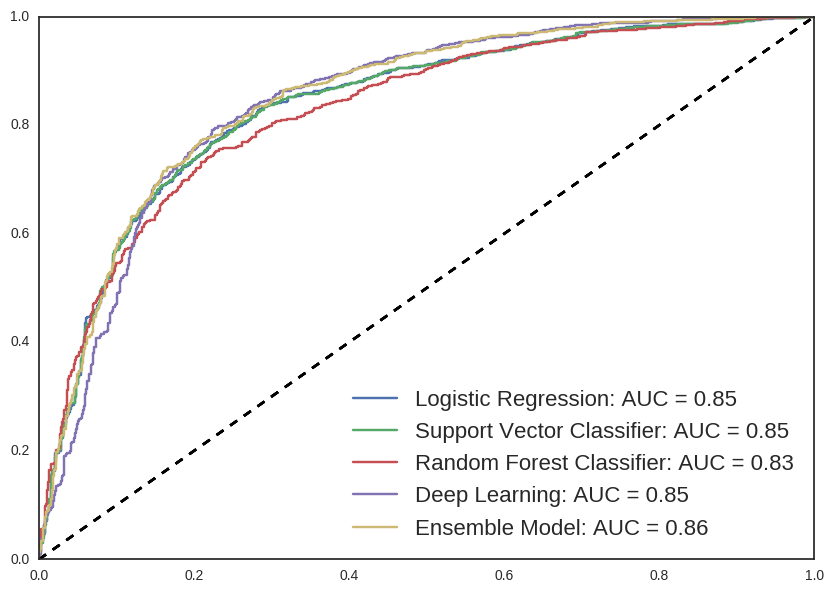

In [54]:
plt.subplots(figsize=(10,7))
for i in range(5):
    plot_roc_curve(roc_vals[0,i,:], roc_probs[0,i,:],clf_names[i],df_avg_scores.loc['AUC',clf_names[i]])

plt.savefig('solubility_ROC.svg',transparent=True,format='svg')

# Feature Importance
[Back to Top](#Table-of-Contents)

In [48]:
from sklearn.base import clone

In [49]:
final_imp = pd.DataFrame(index=list_of_features)
for n in tqdm(range(20)):
    tmp_rf = clone(clfs[2])
    tmp_rf.set_params(random_state=n)
    tmp_rf.fit(X_train,y_train) 
    fx_imp = abs(pd.Series(tmp_rf.feature_importances_,index=list_of_features))
    fx_imp /= fx_imp.max() # normalize
    final_imp.loc[:,n] = fx_imp.sort_values(ascending=False)

100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


In [50]:
final_imp = final_imp.mean(axis=1).sort_values(ascending=0)

In [51]:
colors = []
for name in final_imp.index:
    if name in aa_features:
        colors.append('deepskyblue')
    elif name in phys_features:
        colors.append('green')
    else:
        print('Error: Feature not recognized')
        break

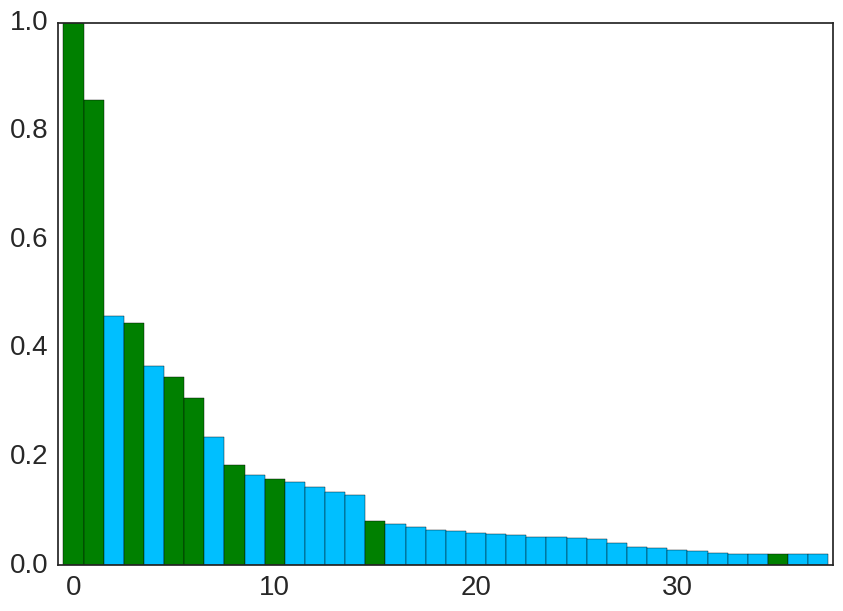

In [52]:
ax = final_imp.plot(kind='bar', color=colors,width=1,figsize=(10,7));
plt.xticks(range(0,len(final_imp),10),range(0,len(final_imp),10),rotation='horizontal');

# plt.savefig(FIGURE_DIR+'feature_importance.svg',transparent=True,format='svg')

In [53]:
fx_imp_short = final_imp.sort_values(ascending=0)[:10]
print fx_imp_short.index

Index([u'bio_aromaticity', u'bio_gravy', u'list_comp_P', u'avg_charge',
       u'list_comp_Y', u'bio_pI', u'bio_mW', u'list_comp_F', u'aa_len',
       u'frac_negative'],
      dtype='object')


In [57]:
new_index=['Aromaticity','GRAVY','% Proline','Average Charge','% Tyrosine']

## Decision Tree

In [58]:
X_dt = DF_prest[final_imp.sort_values(ascending=0)[:5].index].values
y_dt = DF_prest.soluble

In [59]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(max_depth=3,random_state=0).fit(X_dt,1-y_dt)

tree.export_graphviz(dt,out_file='solubility_tree.dot',
                     feature_names=new_index,
                     class_names=['Soluble','Insoluble'],
                     filled=True,impurity=False,leaves_parallel=True,
                     rounded=True)
subprocess.call(['dot','solubility_tree.dot','-Tpng','-o','solubility_tree.png']);